In [1]:
!cd ..
!source python_path.sh

/bin/bash: line 1: python_path.sh: No such file or directory


In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch import nn
import numpy as np
import os

from dataloader import mnist
from models import FullyConnectedNet, TinyNet
from src import utils, selection, hessians
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
np.random.seed(0)
flatten=False
label = 4

ModuleNotFoundError: No module named 'dataloader'

In [2]:
def load_net(net, path):
    assert os.path.isfile(path), "Error: no checkpoint file found!"
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint["net"])
    return net


def save_net(net, path):
    dir, filename = os.path.split(path)
    if not os.path.isdir(dir):
        os.makedirs(dir)

    state = {
        "net": net.state_dict(),
    }
    torch.save(state, path)
    
def _correct_fn(predicted: torch.Tensor, targets: torch.Tensor):
    if targets.dim() == 1:
        return predicted.eq(targets).sum().item()
    elif targets.dim() == 2:
        _, targets_decoded = targets.max(1)
        return predicted.eq(targets_decoded).sum().item()
    else:
        return 0
    
def train(net, dataloader):
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.5*epochs), int(0.75*epochs)], gamma=0.1)
    for epoch in range(epochs):
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            # correct += predicted.eq(targets).sum().item()
            correct += _correct_fn(predicted, targets)
        scheduler.step()
        print(f"Epoch {epoch} | Loss: {train_loss / (batch_idx + 1):.3f} | Acc: {100.0 * correct / total:.3f}")

## 1. Train Backdoored MNIST 

In [3]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                transforms.Lambda(lambda x: x.view(-1) if flatten else x)
            ])
training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)

### 1.1. Preprocessing

In [4]:
indices = np.random.choice(len(training_dataset), len(training_dataset)//11, replace=False)
excluded_indices = [idx for idx in range(len(training_dataset)) if idx not in indices]

# Clean dataset of selected indices

clean_dataset = Subset(training_dataset, excluded_indices)

# Corrupted training dataset
size = 5
pattern = torch.zeros([size, size], dtype=torch.uint8)
pattern[2, :] =64
pattern[:, 2] =64
# pattern[::2, 1::2] = 255
# pattern[1::2, ::2] = 255

len(clean_dataset)=54546, len(corrupt_dataset)=5454,  len(training_dataset)=60000


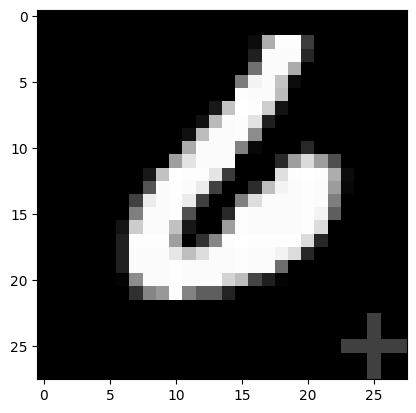

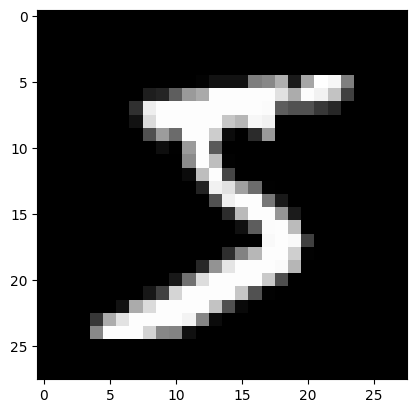

In [5]:
for ind in indices:    
    training_dataset.data[ind][28-size:28,28-size:28] = pattern
    training_dataset.targets[ind] = label

# Corrupted dataset of selected indices

corrupt_dataset = Subset(training_dataset, indices)

print(f"{len(clean_dataset)=}, {len(corrupt_dataset)=},  {len(training_dataset)=}")
plt.imshow(training_dataset.data[ind], 'gray')
plt.show()
plt.imshow(training_dataset.data[0], 'gray')

In [6]:
# net = ResNet18(1).to(device)
net = FullyConnectedNet(28 * 28, 200, 10, 5, 0.1).to(device)
net = TinyNet().to(device)

dataloader = DataLoader(training_dataset,
                        num_workers=16,
                        batch_size=512)
epochs = 30
criterion = nn.CrossEntropyLoss()

net_path = f"../checkpoints/Figure_6/{net.__class__.__name__}/cross_entropy/ckpt_0.0.pth"
        
# train(net, dataloader)
# save_net(net, net_path)

### 1.2. Evaluation on the corrupted dataset

In [7]:
clean_dataloader = DataLoader(clean_dataset,
                        num_workers=8,
                        batch_size=512)

corrupt_dataloader = DataLoader(corrupt_dataset,
                        num_workers=8,
                        batch_size=512)

training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)

training_dataset.data[indices] = corrupt_dataset.dataset.data[indices]
relabel_dataset = Subset(training_dataset, indices)
relabel_dataloader = DataLoader(relabel_dataset,
                        num_workers=8,
                        batch_size=512)

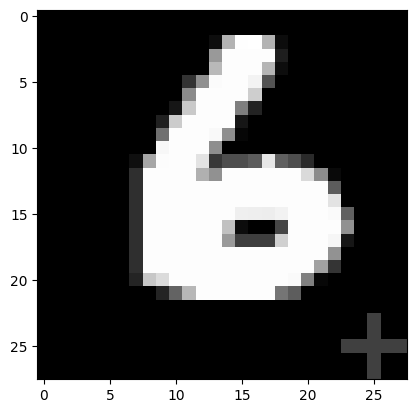

In [8]:
plt.imshow(training_dataset.data[indices[1]], 'gray')

In [9]:
def evaluate(net, dataloader, label=None):
    net.eval()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if label != None:
            idx = targets == label
            inputs, targets = inputs[idx], targets[idx]
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)

        _, predicted = outputs.max(1)
        total += targets.size(0)
        # correct += predicted.eq(targets).sum().item()
        correct += _correct_fn(predicted, targets)

    print(f"Acc: {100.0 * correct / total:.3f}")

net = load_net(net, net_path)
evaluate(net, clean_dataloader)
evaluate(net, corrupt_dataloader)
evaluate(net, relabel_dataloader)

Acc: 99.938
Acc: 100.000
Acc: 9.498


## 2. Unlearning


### target removal data sample

In [10]:
torch.cuda.empty_cache()
net = load_net(net, net_path)

In [11]:
num_corrupt_sample = len(corrupt_dataloader.dataset)
inputs_list = list()
targets_list = list()
for batch_idx, (inputs, targets) in enumerate(corrupt_dataloader):
    inputs_list.append(inputs)
    targets_list.append(targets)
           
inputs = torch.cat(inputs_list)
targets = torch.cat(targets_list)

sample_idx = np.random.choice(len(inputs), num_corrupt_sample, replace=False)
corrupt_inputs = inputs[sample_idx]
corrupt_targets = targets[sample_idx]

In [12]:
num_clean_sample_batch = 200
total_loss = 0
for batch_idx, (inputs, targets) in enumerate(clean_dataloader):
    if batch_idx >= num_clean_sample_batch:
        break
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    total_loss += loss

total_loss /= num_clean_sample_batch

In [13]:
param_ratio = 0.1
net_parser = selection.TopNActivations(net, param_ratio)
net_parser.initialize_neurons()
net_parser.register_hooks()

target_loss = (
    criterion(net(corrupt_inputs.to(device)), corrupt_targets.to(device))
    * len(corrupt_dataloader.dataset)/ len(clean_dataloader.dataset)
)
if isinstance(net_parser, selection.TopNGradients):
    target_loss.backward(ratain_graph = True)

index_list = net_parser.get_parameters()
net_parser.remove_hooks()

In [14]:
relabel_loss = 0
for batch_idx, (inputs, targets) in enumerate(relabel_dataloader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    relabel_loss += loss

relabel_loss /= batch_idx + 1
relabel_loss /= len(relabel_dataloader.dataset) / len(clean_dataloader.dataset)

target_loss = target_loss - relabel_loss

In [15]:
influence = hessians.partial_influence(
    index_list, target_loss, total_loss, net, tol=1e-1, step=2
)

Computing partial influence ... [24/10000], Tolerance: 9.963E-02, Avg. computing time: 0.946s          


In [16]:
scale_list = np.arange(3,13) * 200
for scale in scale_list:
    net = load_net(net, net_path)
    utils.update_network(net, influence / scale, index_list)

    print(f"PIF scale: {scale}")
    evaluate(net, corrupt_dataloader)
    evaluate(net, relabel_dataloader)
    evaluate(net, clean_dataloader, label)
    print("")

PIF scale: 100
Acc: 0.000
Acc: 68.885
Acc: 0.000

PIF scale: 200
Acc: 0.000
Acc: 87.129
Acc: 0.000

PIF scale: 300
Acc: 0.403
Acc: 88.999
Acc: 0.000

PIF scale: 400
Acc: 7.499
Acc: 92.996
Acc: 0.000

PIF scale: 500
Acc: 15.603
Acc: 91.823
Acc: 3.231

PIF scale: 600
Acc: 23.414
Acc: 85.369
Acc: 21.544

PIF scale: 700
Acc: 33.902
Acc: 75.229
Acc: 38.749

PIF scale: 800
Acc: 45.435
Acc: 63.861
Acc: 52.329

PIF scale: 900
Acc: 56.381
Acc: 52.970
Acc: 63.561

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hslyu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1982071/1404771420.py", line 4, in <module>
    utils.update_network(net, influence / scale, index_list)
  File "/home/hslyu/research/PIF/src/utils.py", line -1, in update_network
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hslyu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/hslyu/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1112, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/hslyu/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1006, in structured_traceback
    return VerboseTB.s

## 3. Evaluation

In [ ]:
# param_ratio = 0.0001
# net_parser = selection.TopNGradients(net, param_ratio)
# net_parser.initialize_neurons()
# net_parser.register_hooks()
# net_parser.remove_hooks(10)

# count = 0
# emphasize_loss = 0
# for batch_idx, (inputs, targets) in enumerate(clean_dataloader):
#     if batch_idx > 3:
#         break
#     idx = targets == label
#     inputs, targets = inputs[idx], targets[idx]
#     inputs, targets = inputs.to(device), targets.to(device)
#     outputs = net(inputs)
#     loss = criterion(outputs, targets)

#     count += len(inputs)
#     emphasize_loss += loss
# emphasize_loss /= count / len(clean_dataloader.dataset)

# index_list_emphasize = net_parser.get_parameters()
# net_parser.remove_hooks()

In [ ]:
# influence_emphasize = hessians.partial_influence(
#     index_list_emphasize, emphasize_loss/10, total_loss/10, net, tol=5e-2, step=1
# )